# Introducción

Kaggle describe esta competición de la siguiente manera:

Millones de animales callejeros sufren en las calles o son sacrificados en refugios cada día en todo el mundo. Si se les encuentra un hogar, se salvarán muchas vidas preciosas y se crearán más familias felices.

PetFinder.my es la principal plataforma de bienestar animal de Malasia desde 2008, con una base de datos de más de 150.000 animales. PetFinder colabora estrechamente con amantes de los animales, medios de comunicación, empresas y organizaciones mundiales para mejorar el bienestar animal.

En este concurso se desarrollarán algoritmos para predecir la adoptabilidad de las mascotas, en concreto, con qué rapidez se adopta una mascota. 


# The target variable: Adoption Speed¶
Los concursantes deben predecir este valor. El valor viene determinado por la rapidez con la que se adopta una mascota, si es que se adopta. Los valores se determinan de la siguiente manera:

        - **0** - La mascota fue adoptada el mismo día que se incluyó en la lista.
        - **1** - La mascota fue adoptada entre 1 y 7 días (1ª semana) después de ser incluida en la lista.
        - **2** - La mascota fue adoptada entre 8 y 30 días (1er mes) después de ser incluida en la lista.
        - **3** - La mascota fue adoptada entre 31 y 90 días (2º y 3er mes) después de su inclusión en la lista.
        - **4** - Ninguna adopción después de 100 días de estar en la lista.

# Variables
| Variable        | Descripción                                                                 |
|----------------|------------------------------------------------------------------------------|
| PetID          | Identificador único encriptado del perfil de la mascota.                    |
| AdoptionSpeed  | Velocidad categórica de adopción. Cuanto menor es el número, más rápida fue la adopción. Este es el valor que se debe predecir. |
| Type           | Tipo de animal (1 = Perro, 2 = Gato).                                       |
| Name           | Nombre de la mascota (vacío si no tiene nombre).                            |
| Age            | Edad de la mascota al momento de ser listada, en meses.                     |
| Breed1         | Raza principal de la mascota (consultar el diccionario de etiquetas de razas). |
| Breed2         | Raza secundaria, si la mascota es mestiza (consultar el diccionario de etiquetas de razas). |
| Gender         | Sexo de la mascota (1 = Macho, 2 = Hembra, 3 = Mixto, si el perfil representa un grupo de mascotas). |
| Color1         | Primer color de la mascota (consultar el diccionario de etiquetas de colores). |
| Color2         | Segundo color de la mascota (consultar el diccionario de etiquetas de colores). |
| Color3         | Tercer color de la mascota (consultar el diccionario de etiquetas de colores). |
| MaturitySize   | Tamaño de la mascota cuando alcance la madurez (1 = Pequeño, 2 = Mediano, 3 = Grande, 4 = Extra grande, 0 = No especificado). |
| FurLength      | Longitud del pelaje (1 = Corto, 2 = Medio, 3 = Largo, 0 = No especificado). |
| Vaccinated     | Indica si la mascota ha sido vacunada (1 = Sí, 2 = No, 3 = No está claro).  |
| Dewormed       | Indica si la mascota ha sido desparasitada (1 = Sí, 2 = No, 3 = No está claro). |
| Sterilized     | Indica si la mascota ha sido esterilizada o castrada (1 = Sí, 2 = No, 3 = No está claro). |
| Health         | Estado de salud (1 = Saludable, 2 = Lesión menor, 3 = Lesión grave, 0 = No especificado). |
| Quantity       | Número de mascotas representadas en el perfil.                              |
| Fee            | Tarifa de adopción (0 = Gratuita).                                          |
| State          | Estado (provincia) de ubicación en Malasia (consultar el diccionario de etiquetas de estados). |
| RescuerID      | Identificador único encriptado de la persona rescatista.                    |
| VideoAmt       | Cantidad total de videos subidos para esta mascota.                         |
| PhotoAmt       | Cantidad total de fotos subidas para esta mascota.                          |
| Description    | Descripción del perfil de la mascota. El idioma principal es inglés, aunque también puede haber partes en malayo o chino. |


# Ingesta de Datos

In [265]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
from wordcloud import WordCloud

In [266]:
print(os.listdir("./input/petfinder-adoption-prediction"))

['test_images', 'breed_labels.csv', '.DS_Store', 'test', 'train_metadata', 'color_labels.csv', 'test_sentiment', 'test_metadata', 'StateLabels.csv', 'ColorLabels.csv', 'PetFinder-BreedLabels.csv', 'train_sentiment', 'train', 'BreedLabels.csv', 'PetFinder-ColorLabels.csv', 'train_images', 'PetFinder-StateLabels.csv', 'state_labels.csv']


In [267]:
train_dtypes = {
        'PetID':                            'str',
        'AdoptionSpeed ':                   'int8',
        'Type':                             'int',
        'Name':                             'str',
        'Age':                              'int8',
        'Breed1':                           'category',
        'Breed2':                           'category',
        'Gender':                           'category',
        'Color1':                           'category',
        'Color2':                           'category',
        'Color3':                           'category',
        'MaturitySize':                     'float16',
        'FurLength':                        'int8',
        'Vaccinated':                       'category',
        'Dewormed':                         'category',
        'Sterilized':                       'category',
        'Health':                           'category',
        'Quantity':                         'uint16',
        'State':                            'category',
        'Fee':                              'float',
        'RescuerID':                        'category',
        'VideoAmt':                         'uint16',
        'PhotoAmt':                         'uint16',
        'Description ':                     'str'
        }

breeds_dtypes = {
        'BreedID':                          'category',
        'Type ':                            'category',
        'BreedName':                        'str'
        }

colors_dtypes = {
        'ColorID':                          'category',
        'ColorName':                        'str'
        }

states_dtypes = {
        'StateID':                          'category',
        'StateName':                        'str'
        }

In [268]:
main_path = './input/petfinder-adoption-prediction/'

In [269]:
breeds = pd.read_csv(f'{main_path}breed_labels.csv', dtype=breeds_dtypes)
colors = pd.read_csv(f'{main_path}color_labels.csv',  dtype=colors_dtypes)
states = pd.read_csv('./input/petfinder-adoption-prediction/state_labels.csv', dtype=states_dtypes)

train = pd.read_csv(f'{main_path}train/train.csv', dtype=train_dtypes)

df = train.copy()

# Exploracion del Dataset

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Type           14993 non-null  int64   
 1   Name           13728 non-null  object  
 2   Age            14993 non-null  int8    
 3   Breed1         14993 non-null  category
 4   Breed2         14993 non-null  category
 5   Gender         14993 non-null  category
 6   Color1         14993 non-null  category
 7   Color2         14993 non-null  category
 8   Color3         14993 non-null  category
 9   MaturitySize   14993 non-null  float16 
 10  FurLength      14993 non-null  int8    
 11  Vaccinated     14993 non-null  category
 12  Dewormed       14993 non-null  category
 13  Sterilized     14993 non-null  category
 14  Health         14993 non-null  category
 15  Quantity       14993 non-null  uint16  
 16  Fee            14993 non-null  float64 
 17  State          14993 non-null  

In [271]:
df.sample(10).T

,10360,14336,14043,5061,7920,5899,4700,3927,4019,6097
Type,1,1,2,1,1,1,2,1,2,2
Name,Norman,Prince,Russia,NaN,4 Adorable Puppies,6 Puppies,Polar & Panther,Yoda 03,NaN,Anjeli
Age,30,6,96,36,2,1,4,1,6,4
Breed1,195,307,289,307,307,307,251,307,241,266
Breed2,179,0,0,0,0,141,292,0,276,0
Gender,1,1,2,1,3,2,3,2,2,2
Color1,1,1,6,5,2,1,1,1,1,7
Color2,0,0,0,6,0,2,0,7,6,0
Color3,0,0,0,0,0,0,0,0,0,0
MaturitySize,1.0,2.0,4.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0


In [272]:
df.shape

(14993, 24)

In [273]:
# Diccionarios de mapeo basados en tu descripción
map_type = {1: 'Perros', 2: 'Gatos'}
map_gender = {1: 'Macho', 2: 'Hembra', 3: 'Mixto'}
map_maturity = {1: 'Pequeño', 2: 'Mediano', 3: 'Grande', 4: 'Extra grande', 0: 'No especificado'}
map_furlength = {1: 'Corto', 2: 'Medio', 3: 'Largo', 0: 'No especificado'}
map_vaccinated = {1: 'Sí', 2: 'No', 3: 'No claro'}
map_dewormed = {1: 'Sí', 2: 'No', 3: 'No claro'}
map_sterilized = {1: 'Sí', 2: 'No', 3: 'No claro'}
map_health = {1: 'Saludable', 2: 'Lesión menor', 3: 'Lesión grave', 0: 'No especificado'}
adoption_order = [
    "mismo día",
    "1-7 días",
    "8-30 días",
    "31-90 días",
    "(90+ días)"
]


In [274]:
from pandas.api.types import CategoricalDtype

In [275]:
# Tipo categórico ordenado para AdoptionSpeed
adoption_cat_type = CategoricalDtype(categories=adoption_order, ordered=True)

In [276]:
# Copiamos el DataFrame original
df_expl = df.copy()

In [277]:
# Aplicamos los mapeos a las columnas codificadas
df_expl['Type'] = df_expl['Type'].astype('int').map(map_type)
df_expl['Gender'] = df_expl['Gender'].astype('int').map(map_gender)
df_expl['MaturitySize'] = df_expl['MaturitySize'].astype('int').map(map_maturity)
df_expl['FurLength'] = df_expl['FurLength'].astype('int').map(map_furlength)
df_expl['Vaccinated'] = df_expl['Vaccinated'].astype('int').map(map_vaccinated)
df_expl['Dewormed'] = df_expl['Dewormed'].astype('int').map(map_dewormed)
df_expl['Sterilized'] = df_expl['Sterilized'].astype('int').map(map_sterilized)
df_expl['Health'] = df_expl['Health'].astype('int').map(map_health)
#df_expl['AdoptionSpeed'] = df_expl['AdoptionSpeed'].astype('int').map(map_adoption_speed)
# 🔁 Map + tipo categórico ordenado
df_expl['AdoptionSpeed'] = df_expl['AdoptionSpeed'].astype('int').map(map_adoption_speed)
df_expl['AdoptionSpeed'] = df_expl['AdoptionSpeed'].astype(adoption_cat_type)

In [278]:
df_expl.sample(10).T

,3769,2586,8746,6198,96,5038,11345,8359,5452,10474
Type,Perros,Gatos,Perros,Perros,Gatos,Gatos,Perros,Perros,Gatos,Gatos
Name,T1,Apam,G3,Corner Boy,Manja,Racoon@tompok,The 3 Musketeers,Money @,Choco And Latto,Double Monsters
Age,2,12,2,4,19,6,3,2,4,3
Breed1,307,265,307,307,285,266,307,307,266,282
Breed2,307,0,307,0,0,0,0,307,264,283
Gender,Macho,Macho,Hembra,Macho,Hembra,Hembra,Mixto,Macho,Macho,Macho
Color1,5,2,2,1,1,1,1,1,1,2
Color2,0,7,0,2,6,7,2,7,2,4
Color3,0,0,0,3,0,0,7,0,5,7
MaturitySize,Mediano,Grande,Mediano,Grande,Grande,Mediano,Mediano,Mediano,Mediano,Pequeño


Distribucion de la variable target

In [279]:
df_expl['AdoptionSpeed'].value_counts().to_frame('Cantidad').assign(Porcentaje=lambda x: x/x.sum()*100)

,Cantidad,Porcentaje
AdoptionSpeed,,
(90+ días),4197,27.993063
8-30 días,4037,26.925899
31-90 días,3259,21.736811
1-7 días,3090,20.609618
mismo día,410,2.734609


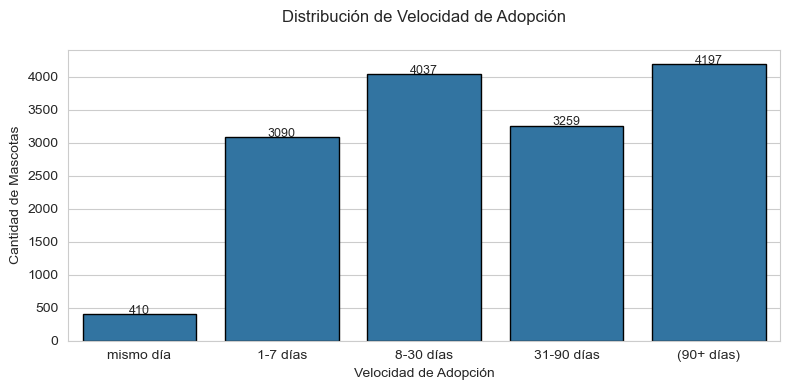

In [280]:
# Preparar datos
adoption_counts = df_expl['AdoptionSpeed'].value_counts().sort_index().reset_index()
adoption_counts.columns = ['AdoptionSpeed', 'count']


# Crear gráfico
plt.figure(figsize=(8, 4))
ax = sns.barplot(
    data=adoption_counts,
    x='AdoptionSpeed',
    y='count',
    #palette=colors,
    edgecolor='black'
)

# Etiquetas y título
plt.title('Distribución de Velocidad de Adopción', pad=20)
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad de Mascotas')

# Etiquetas sobre las barras
for i, row in adoption_counts.iterrows():
    ax.text(i, row['count'] + 2, row['count'], ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [281]:
df_expl.sample(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
200,Gatos,Baby,2,265,0,Macho,5,0,0,Pequeño,...,Saludable,1,0.0,41327,550e496b62e645bffa3dd9c147ba264c,0,"I am posting on behalf of Bee Lian, my neighbo...",06296e4e2,6,(90+ días)
1160,Perros,Freckles,3,307,0,Hembra,7,0,0,Mediano,...,Saludable,1,0.0,41326,6177ae3a4951ab8c0fb21cb9cc739e80,0,Quite big for her age of 3 months. Super-intel...,5b56430cd,1,31-90 días


<Figure size 1200x600 with 0 Axes>

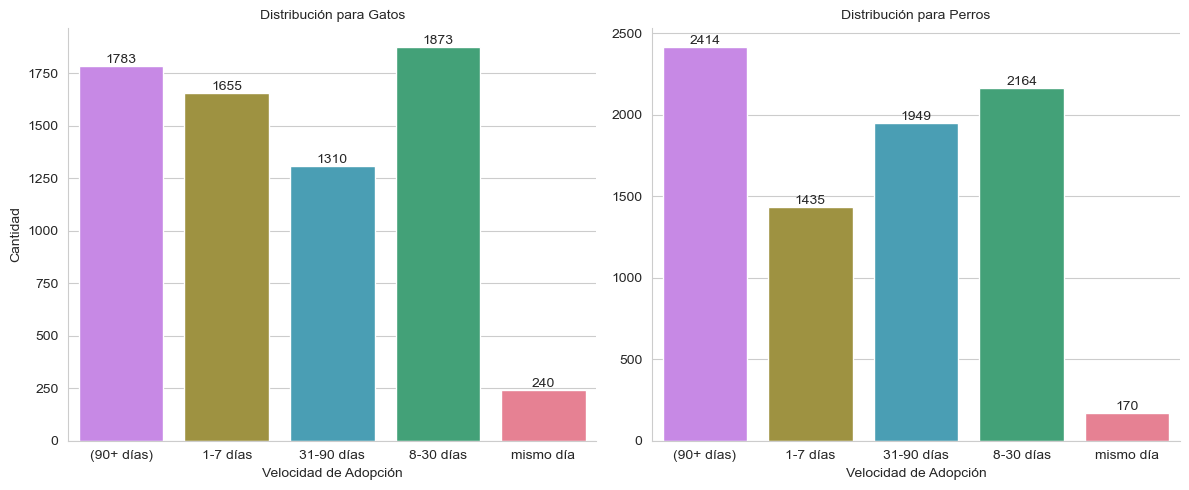

In [282]:
# Preparar los datos
plot_data = df_expl[df_expl['Type'].isin(['Perros', 'Gatos'])].copy()
#plot_data['Type'] = plot_data['Type'].map({1: 'Perros', 2: 'Gatos'})

# Configuración
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Crear el gráfico
g = sns.FacetGrid(plot_data, col='Type', height=5, aspect=1.2, sharey=False)
g.map_dataframe(
    sns.countplot,
    x='AdoptionSpeed',
    hue='AdoptionSpeed',  # Soluciona el warning de palette
    palette='husl',
    order=sorted(plot_data['AdoptionSpeed'].unique()),
    legend=False  # Evita que muestre la leyenda de hue
)

# Configurar títulos y etiquetas
g.set_axis_labels('Velocidad de Adopción', 'Cantidad')
g.set_titles(col_template='Distribución para {col_name}')  # Corrige el KeyError

# Añadir los valores en las barras
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

plt.tight_layout()
plt.show()

In [283]:
# Contar las ocurrencias de cada combinación
conteo = df_expl.groupby(['AdoptionSpeed', 'Type']).size().reset_index(name='Conteo')

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2315931401.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = df_expl.groupby(['AdoptionSpeed', 'Type']).size().reset_index(name='Conteo')


In [284]:
conteo

,AdoptionSpeed,Type,Conteo
0,mismo día,Gatos,240
1,mismo día,Perros,170
2,1-7 días,Gatos,1655
3,1-7 días,Perros,1435
4,8-30 días,Gatos,1873
5,8-30 días,Perros,2164
6,31-90 días,Gatos,1310
7,31-90 días,Perros,1949
8,(90+ días),Gatos,1783
9,(90+ días),Perros,2414


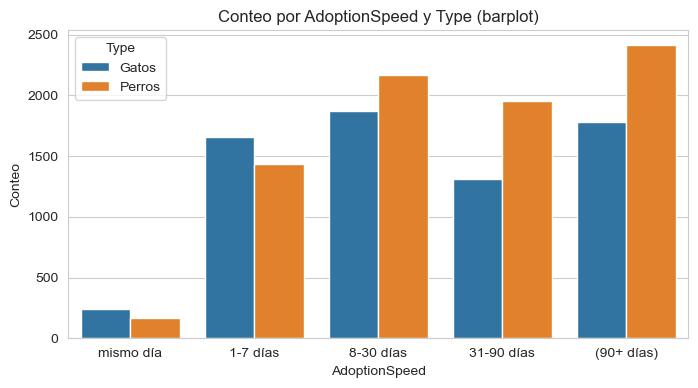

In [285]:
# Método 2: Usando barplot con los datos pre-agrupados
plt.figure(figsize=(8, 4))
sns.barplot(x='AdoptionSpeed', y='Conteo', hue='Type', data=conteo)
plt.title('Conteo por AdoptionSpeed y Type (barplot)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Type')
plt.show()

In [286]:
df_expl['Type'].value_counts().to_frame('Cantidad').assign(Porcentaje=lambda x: x/x.sum()*100)

,Cantidad,Porcentaje
Type,,
Perros,8132,54.238645
Gatos,6861,45.761355


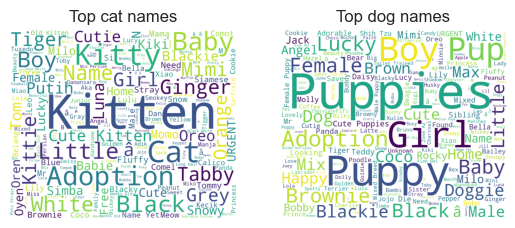

In [287]:
plt.subplot(1, 2, 1)
text_cat = ' '.join(df_expl.loc[df_expl['Type'] == 'Gatos', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(df_expl.loc[df_expl['Type'] == 'Perros', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

In [288]:
df_expl

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,Gatos,Nibble,3,299,0,Macho,1,7,0,Pequeño,...,Saludable,1,100.0,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,8-30 días
1,Gatos,No Name Yet,1,265,0,Macho,1,2,0,Mediano,...,Saludable,1,0.0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,mismo día
2,Perros,Brisco,1,307,0,Macho,2,7,0,Mediano,...,Saludable,1,0.0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,31-90 días
3,Perros,Miko,4,307,0,Hembra,1,2,0,Mediano,...,Saludable,1,150.0,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,8-30 días
4,Perros,Hunter,1,307,0,Macho,1,0,0,Mediano,...,Saludable,1,0.0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,8-30 días
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,Gatos,NaN,2,266,0,Mixto,1,0,0,Mediano,...,Saludable,4,0.0,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,8-30 días
14989,Gatos,Serato & Eddie,60,265,264,Mixto,1,4,7,Mediano,...,Saludable,2,0.0,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,(90+ días)
14990,Gatos,Monkies,2,265,266,Mixto,5,6,7,Grande,...,Saludable,5,30.0,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,31-90 días
14991,Gatos,Ms Daym,9,266,0,Hembra,4,7,0,Pequeño,...,Saludable,1,0.0,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,(90+ días)


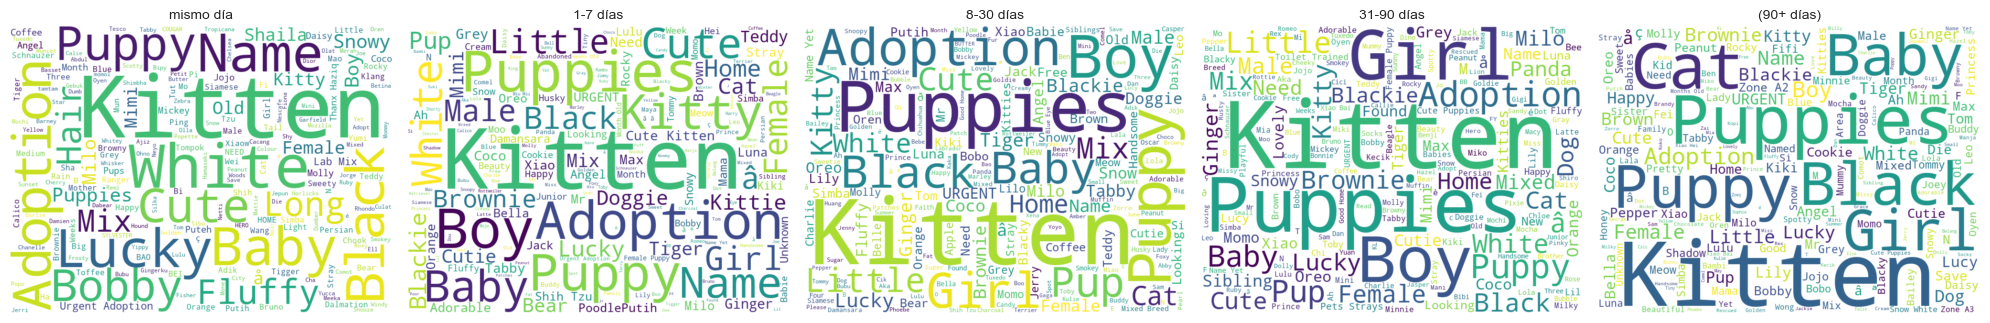

In [289]:
# Nos aseguramos de que esté en texto legible y ordenado (categorical ordenado)
adoption_categories = df_expl['AdoptionSpeed'].cat.categories

# Configuramos el tamaño del gráfico
fig, axes = plt.subplots(1, len(adoption_categories), figsize=(20, 6))

# Para cada categoría de adopción
for i, adoption_label in enumerate(adoption_categories):
    text = ' '.join(
        df_expl.loc[df_expl['AdoptionSpeed'] == adoption_label, 'Name'].fillna('').astype(str)
    )
    wordcloud = WordCloud(max_font_size=None, background_color='white',
                          width=800, height=600).generate(text)
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(adoption_label, fontsize=10)

plt.tight_layout()
plt.show()

# Uniones con informacion relevante

In [290]:
df_expl

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,Gatos,Nibble,3,299,0,Macho,1,7,0,Pequeño,...,Saludable,1,100.0,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,8-30 días
1,Gatos,No Name Yet,1,265,0,Macho,1,2,0,Mediano,...,Saludable,1,0.0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,mismo día
2,Perros,Brisco,1,307,0,Macho,2,7,0,Mediano,...,Saludable,1,0.0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,31-90 días
3,Perros,Miko,4,307,0,Hembra,1,2,0,Mediano,...,Saludable,1,150.0,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,8-30 días
4,Perros,Hunter,1,307,0,Macho,1,0,0,Mediano,...,Saludable,1,0.0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,8-30 días
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,Gatos,NaN,2,266,0,Mixto,1,0,0,Mediano,...,Saludable,4,0.0,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,8-30 días
14989,Gatos,Serato & Eddie,60,265,264,Mixto,1,4,7,Mediano,...,Saludable,2,0.0,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,(90+ días)
14990,Gatos,Monkies,2,265,266,Mixto,5,6,7,Grande,...,Saludable,5,30.0,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,31-90 días
14991,Gatos,Ms Daym,9,266,0,Hembra,4,7,0,Pequeño,...,Saludable,1,0.0,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,(90+ días)


In [291]:
breeds

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita
...,...,...,...
302,302,2,Torbie
303,303,2,Tortoiseshell
304,304,2,Turkish Angora
305,305,2,Turkish Van


In [292]:
# Unificamos la información de razas (Breed1 y Breed2)
breeds = breeds.rename(columns={"BreedID": "Breed1"})

# Merge para Breed1
df_expl = pd.merge(df_expl, breeds[["Breed1", "BreedName"]], how="left", on="Breed1")
df_expl = df_expl.rename(columns={"BreedName": "BreedName_1"})

# Preparación y merge para Breed2
breeds = breeds.rename(columns={"Breed1": "Breed2"})  # reutilizamos el DataFrame cambiando la columna
df_expl = pd.merge(df_expl, breeds[["Breed2", "BreedName"]], how="left", on="Breed2")
df_expl = df_expl.rename(columns={"BreedName": "BreedName_2"})


# Unificamos la información de colores (Color1, Color2, Color3)
colors = colors.rename(columns={"ColorID": "Color1"})

# Merge para Color1
df_expl = pd.merge(df_expl, colors[["Color1", "ColorName"]], how="left", on="Color1")
df_expl = df_expl.rename(columns={"ColorName": "ColorName_1"})

# Preparación y merge para Color2
colors = colors.rename(columns={"Color1": "Color2"})
df_expl = pd.merge(df_expl, colors[["Color2", "ColorName"]], how="left", on="Color2")
df_expl = df_expl.rename(columns={"ColorName": "ColorName_2"})

# Preparación y merge para Color3
colors = colors.rename(columns={"Color2": "Color3"})
df_expl = pd.merge(df_expl, colors[["Color3", "ColorName"]], how="left", on="Color3")
df_expl = df_expl.rename(columns={"ColorName": "ColorName_3"})


# Unificamos la información de estados
states = states.rename(columns={"StateID": "State"})
df_expl = pd.merge(df_expl, states[["State", "StateName"]], how="left", on="State")

# Visualización rápida del resultado
df_expl.head(4)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Description,PetID,PhotoAmt,AdoptionSpeed,BreedName_1,BreedName_2,ColorName_1,ColorName_2,ColorName_3,StateName
0,Gatos,Nibble,3,299,0,Macho,1,7,0,Pequeño,...,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,8-30 días,Tabby,NaN,Black,White,NaN,Selangor
1,Gatos,No Name Yet,1,265,0,Macho,1,2,0,Mediano,...,I just found it alone yesterday near my apartm...,6296e909a,2,mismo día,Domestic Medium Hair,NaN,Black,Brown,NaN,Kuala Lumpur
2,Perros,Brisco,1,307,0,Macho,2,7,0,Mediano,...,Their pregnant mother was dumped by her irresp...,3422e4906,7,31-90 días,Mixed Breed,NaN,Brown,White,NaN,Selangor
3,Perros,Miko,4,307,0,Hembra,1,2,0,Mediano,...,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,8-30 días,Mixed Breed,NaN,Black,Brown,NaN,Kuala Lumpur


In [293]:
df_expl.sample(5).T

,11318,8670,11772,11153,830
Type,Gatos,Gatos,Gatos,Perros,Gatos
Name,Boi Boi,Tonny,Snow,NaN,Tikus
Age,24,5,2,1,1
Breed1,295,266,265,307,266
Breed2,0,0,265,0,0
Gender,Macho,Macho,Hembra,Hembra,Macho
Color1,3,1,7,1,1
Color2,0,2,0,7,6
Color3,0,0,0,0,7
MaturitySize,Mediano,Grande,Mediano,Mediano,Pequeño


In [294]:
df_expl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Type           14993 non-null  object  
 1   Name           13728 non-null  object  
 2   Age            14993 non-null  int8    
 3   Breed1         14993 non-null  object  
 4   Breed2         14993 non-null  object  
 5   Gender         14993 non-null  object  
 6   Color1         14993 non-null  category
 7   Color2         14993 non-null  object  
 8   Color3         14993 non-null  object  
 9   MaturitySize   14993 non-null  object  
 10  FurLength      14993 non-null  object  
 11  Vaccinated     14993 non-null  object  
 12  Dewormed       14993 non-null  object  
 13  Sterilized     14993 non-null  object  
 14  Health         14993 non-null  object  
 15  Quantity       14993 non-null  uint16  
 16  Fee            14993 non-null  float64 
 17  State          14993 non-null  

In [313]:
def plot_categorical_distribution_prop(dfs, column, target='AdoptionSpeed'):
    plt.figure(figsize=(8, 4))
    
    # Agrupar y calcular proporciones por categoría
    grouped = dfs.groupby([column, target]).size().reset_index(name='count')
    total_per_cat = grouped.groupby(column)['count'].transform('sum')
    grouped['Proportion'] = grouped['count'] / total_per_cat

    sns.barplot(data=grouped, x=column, y='Proportion', hue=target)
    plt.title(f'{column} vs {target}')
    plt.ylabel('Proporción por categoría')
    plt.legend(title=target)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [315]:
def plot_categorical_distribution_tot(dfs, column, target='AdoptionSpeed'):
    plt.figure(figsize=(8, 4))
    
    # Agrupar y calcular proporciones por categoría
    grouped = dfs.groupby([column, target]).size().reset_index(name='count')
    #total_per_cat = grouped.groupby(column)['count'].transform('sum')
    #grouped['Proportion'] = grouped['count'] / total_per_cat

    sns.barplot(data=grouped, x=column, y='count', hue=target)
    plt.title(f'{column} vs {target}')
    plt.ylabel('Total por categoría')
    plt.legend(title=target)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [299]:
# Aplicar a variables categóricas principales
categorical_cols = [
    "Gender", "Vaccinated", "Dewormed", "Sterilized",
    "Health", "FurLength", 'MaturitySize'
]

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/109083217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


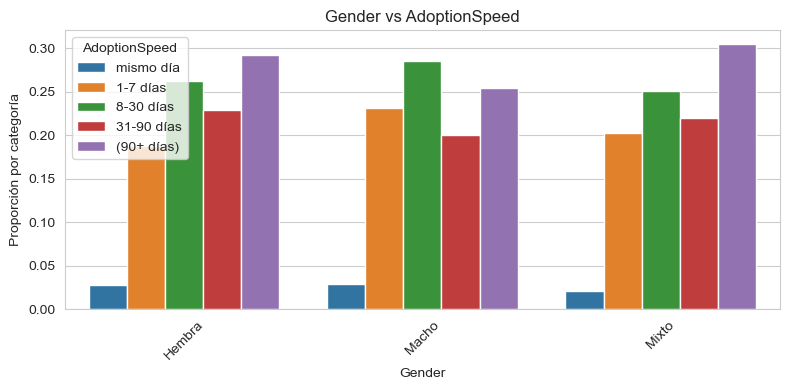

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/109083217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


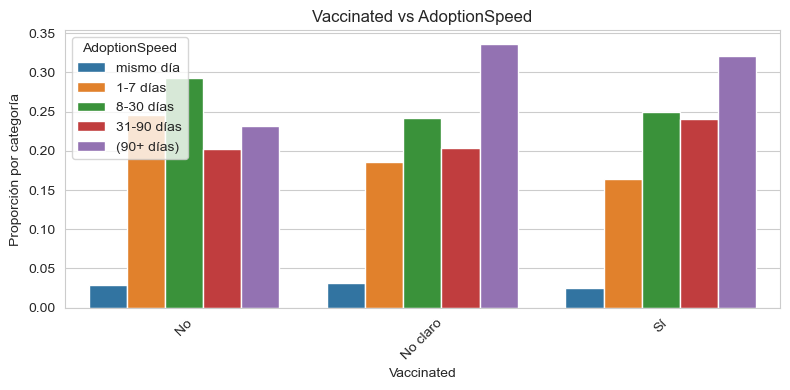

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/109083217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


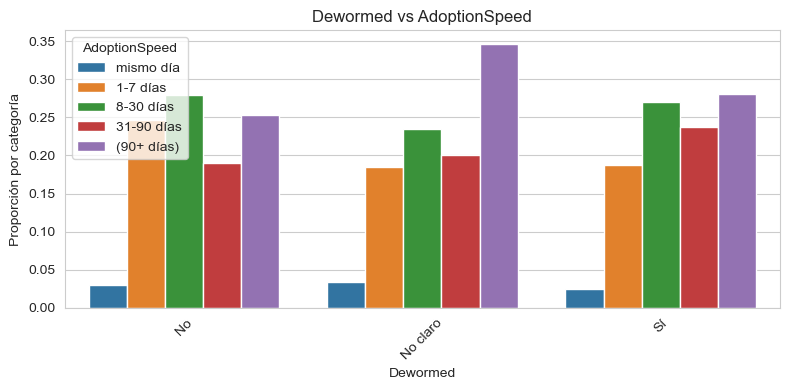

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/109083217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


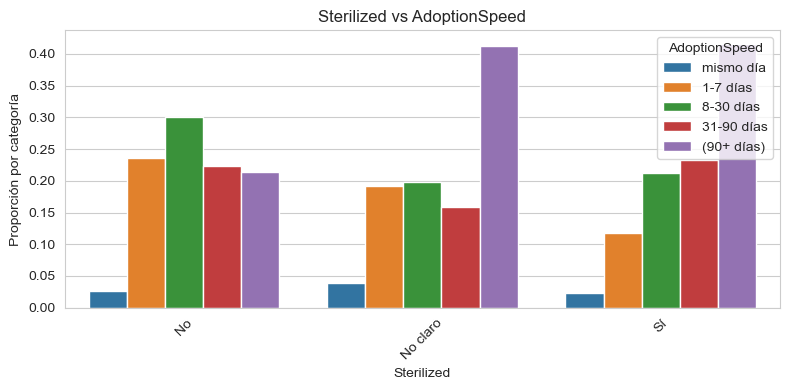

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/109083217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


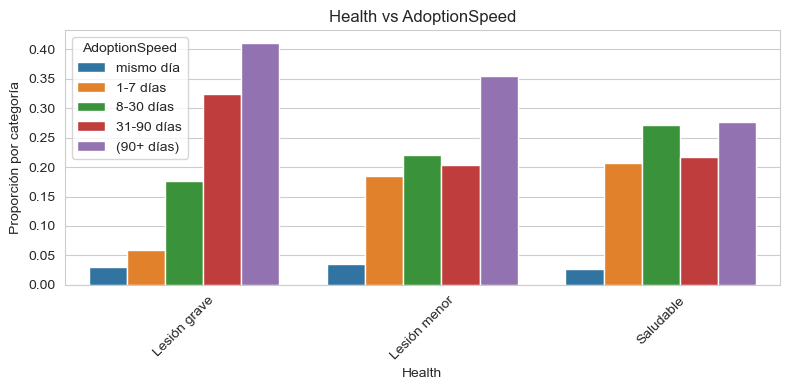

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/109083217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


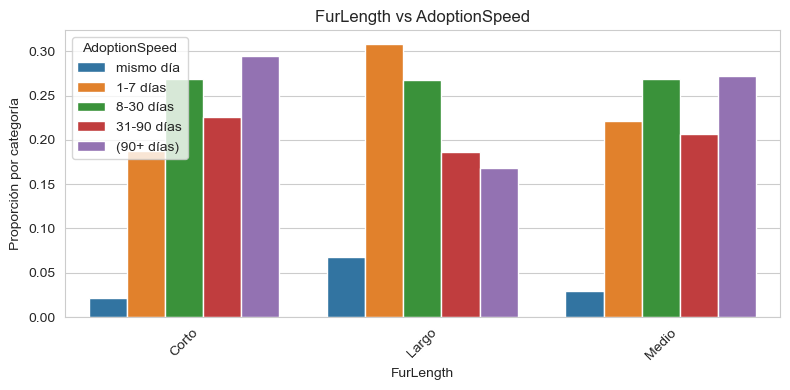

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/109083217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


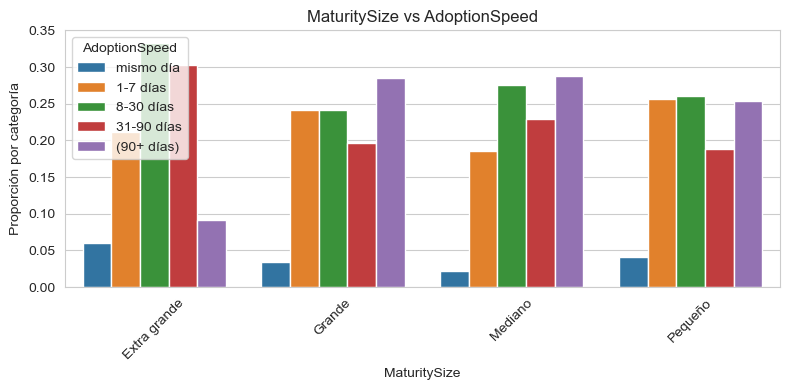

In [314]:
for col in categorical_cols:
    plot_categorical_distribution_prop(df_expl, col)

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2873578259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


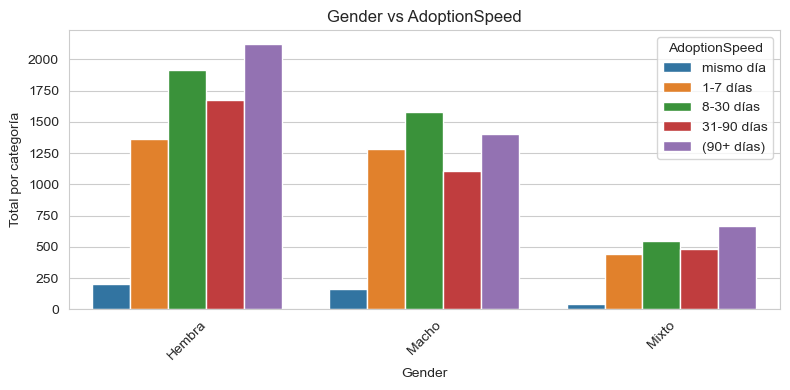

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2873578259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


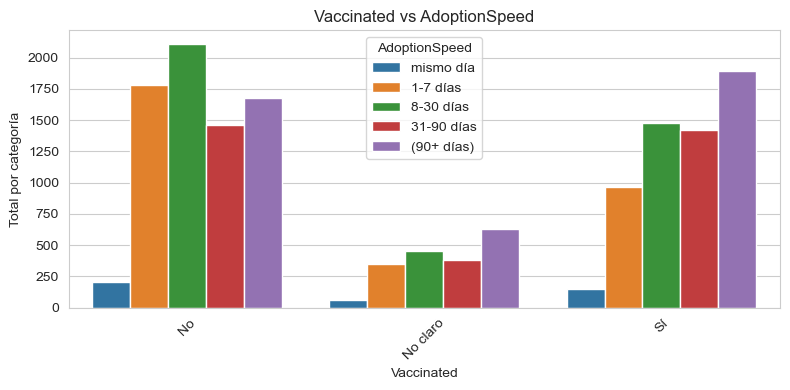

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2873578259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


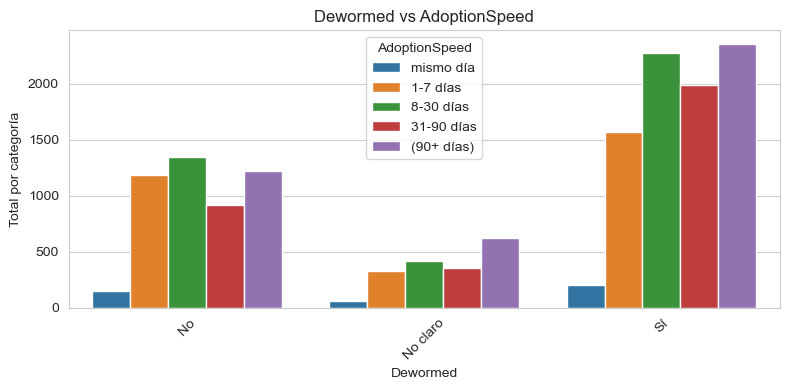

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2873578259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


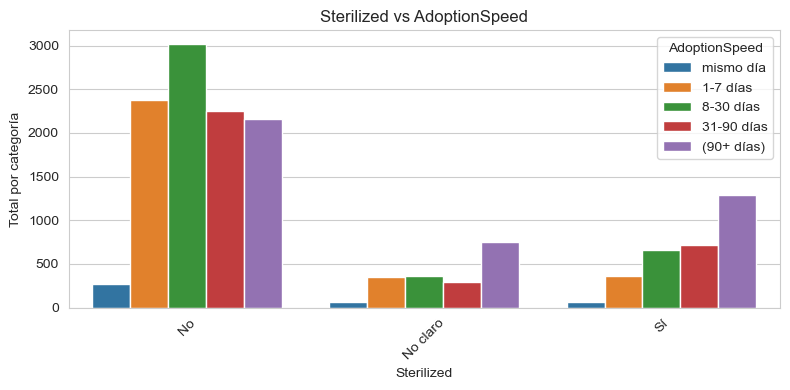

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2873578259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


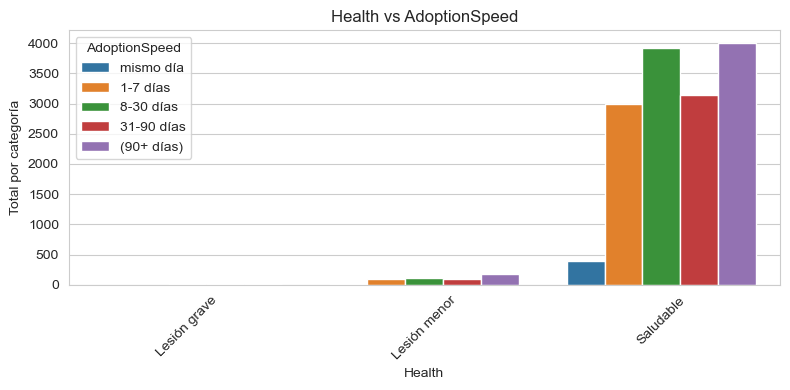

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2873578259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


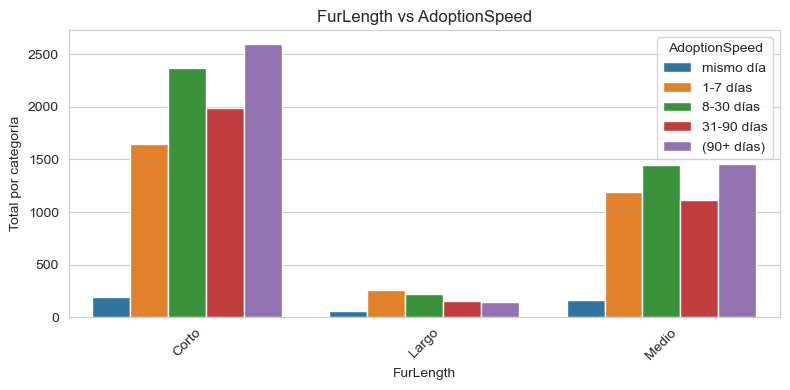

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/2873578259.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


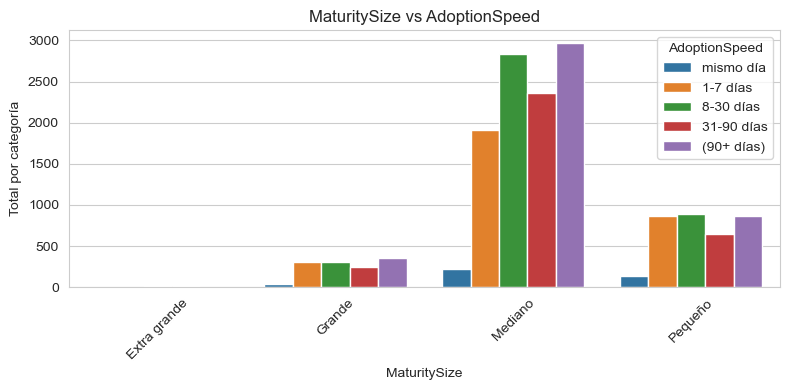

In [316]:
for col in categorical_cols:
    plot_categorical_distribution_tot(df_expl, col)

## Columnas numericas

In [319]:
def plot_numeric_boxplot(df, column, target='AdoptionSpeed'):
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, y=target, x=column)
    plt.title(f'{column} distribuido por {target}')
    plt.tight_layout()
    plt.show()

numeric_cols = ["Age", "Fee", "Quantity", "PhotoAmt", "VideoAmt"]

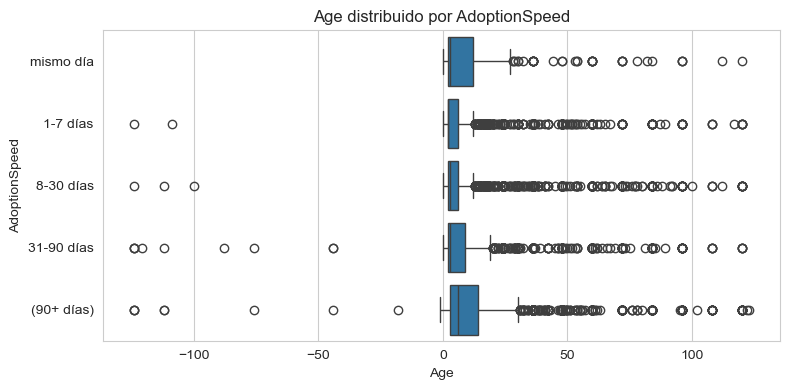

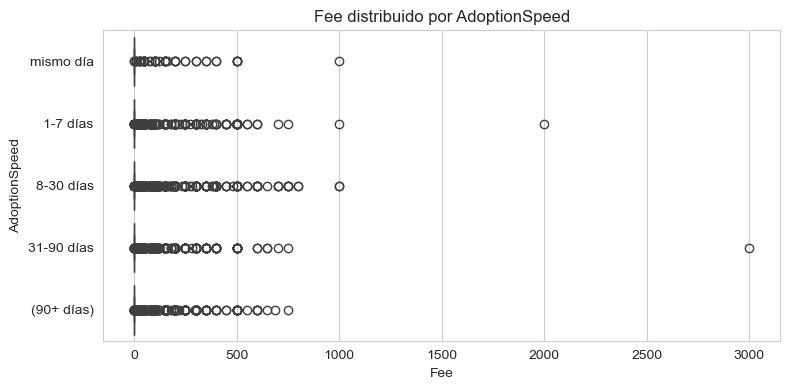

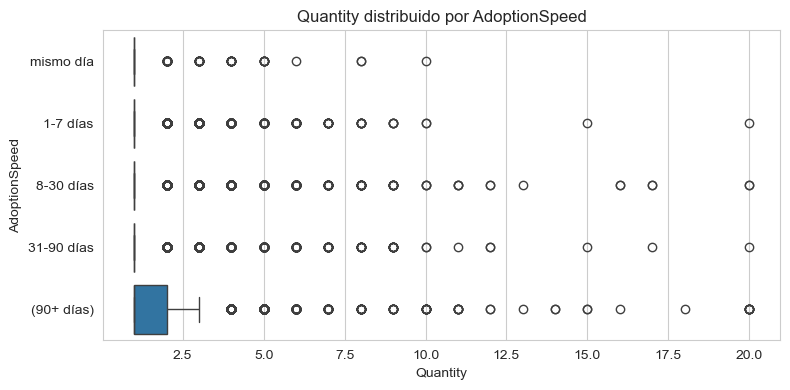

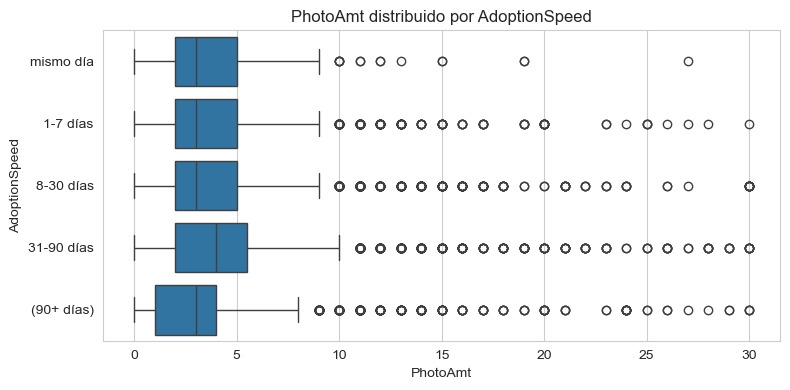

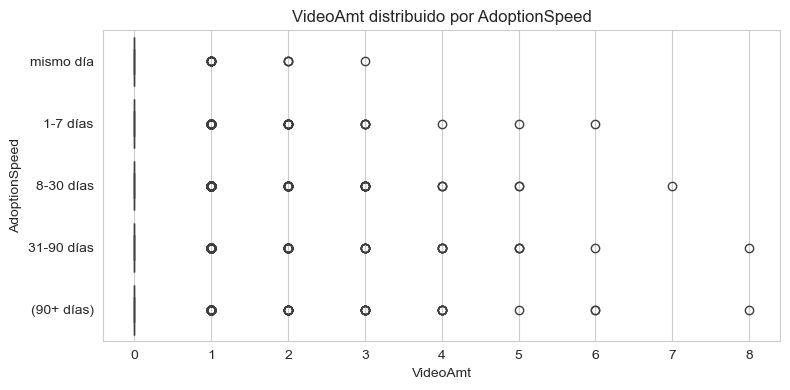

In [320]:
for col in numeric_cols:
    plot_numeric_boxplot(df_expl, col)

In [323]:
def plot_numeric_boxplot_out(df, column, target='AdoptionSpeed', std_range=3):
    """
    Grafica un boxplot para una variable numérica contra la variable target,
    limitando los valores a ± std_range desviaciones estándar de la media.
    """
    mean = df[column].mean()
    std = df[column].std()
    
    lower = mean - std_range * std
    upper = mean + std_range * std

    # Filtrar valores fuera del rango
    filtered_df = df[(df[column] >= lower) & (df[column] <= upper)]

    plt.figure(figsize=(8, 4))
    sns.boxplot(data=filtered_df, y=target, x=column)
    plt.title(f'{column} distribuido por {target}\n(Rango ±{std_range}σ)')
    plt.tight_layout()
    plt.show()

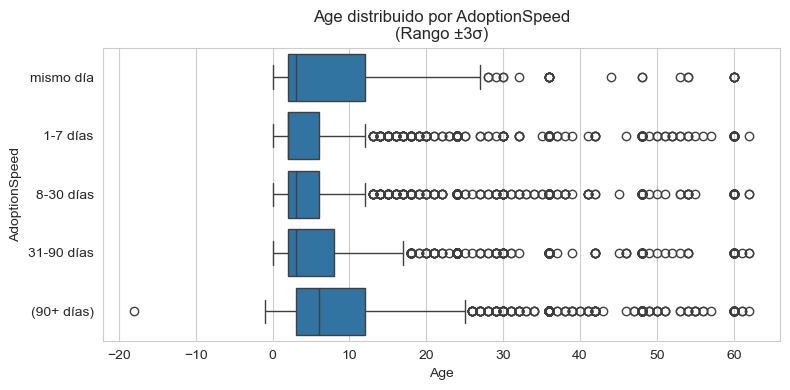

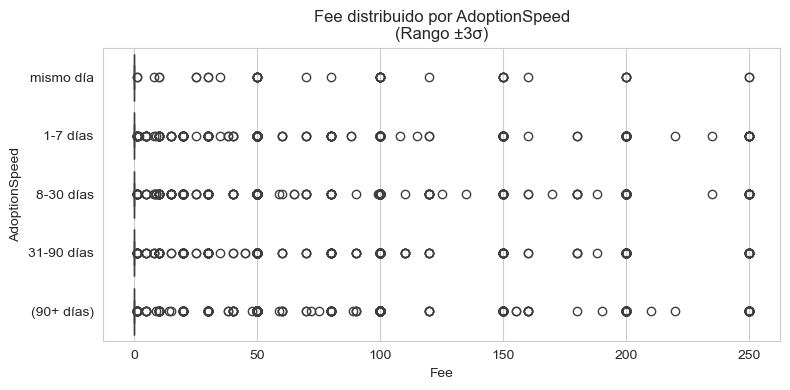

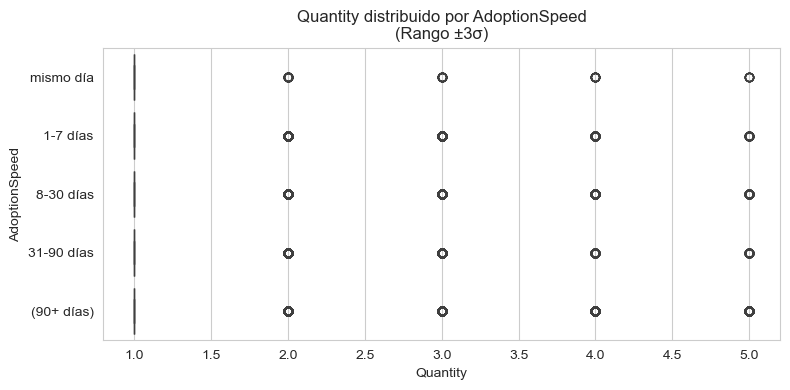

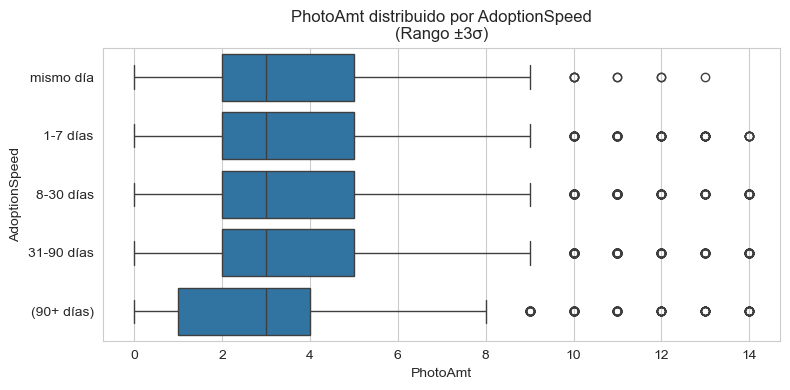

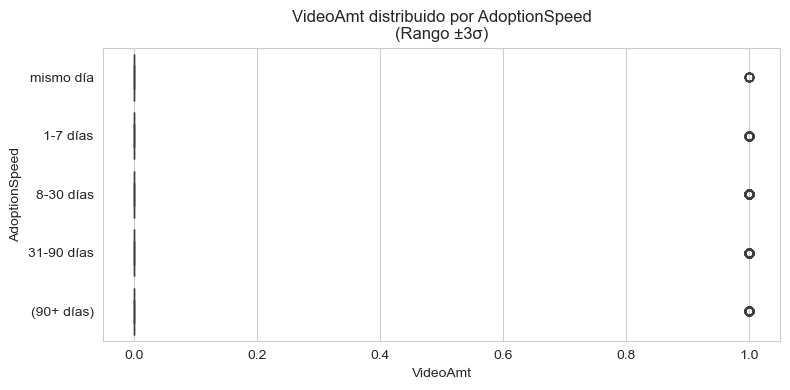

In [327]:
for col in numeric_cols:
    plot_numeric_boxplot_out(df_expl, col, std_range=3)  # 3 sigma es común

In [328]:
def plot_kde_by_adoption(df, column, target='AdoptionSpeed'):
    plt.figure(figsize=(10, 5))
    for speed in sorted(df[target].unique()):
        sns.kdeplot(df[df[target]==speed][column], label=f'AdoptionSpeed {speed}', fill=True)
    plt.title(f'Distribución KDE de {column} según {target}')
    plt.legend()
    plt.tight_layout()
    plt.show()

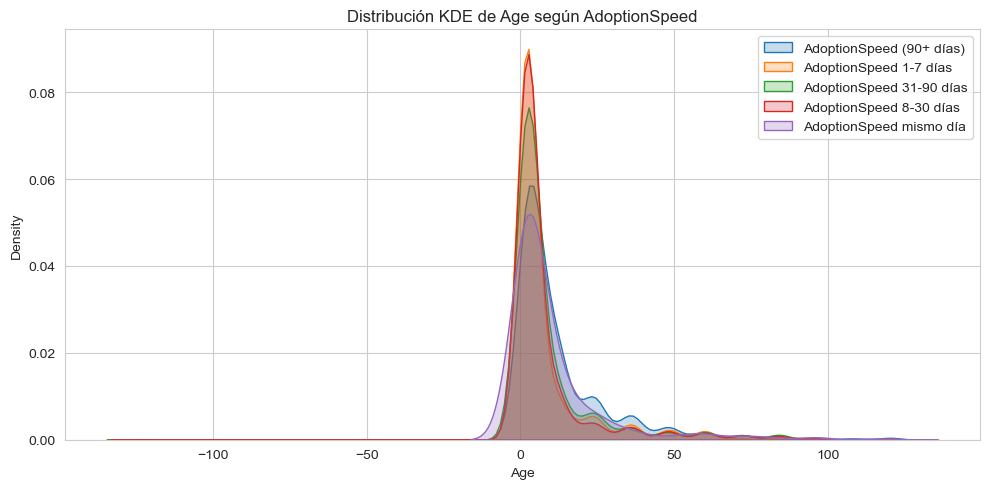

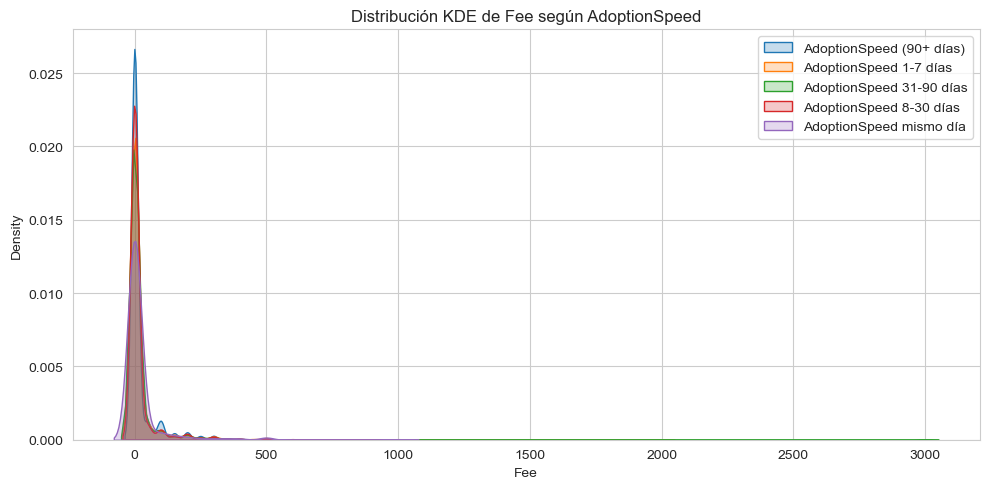

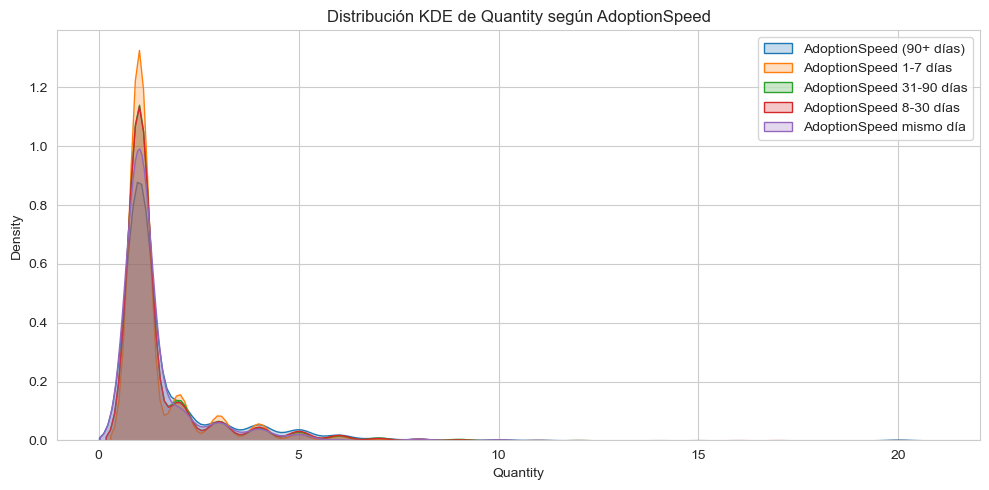

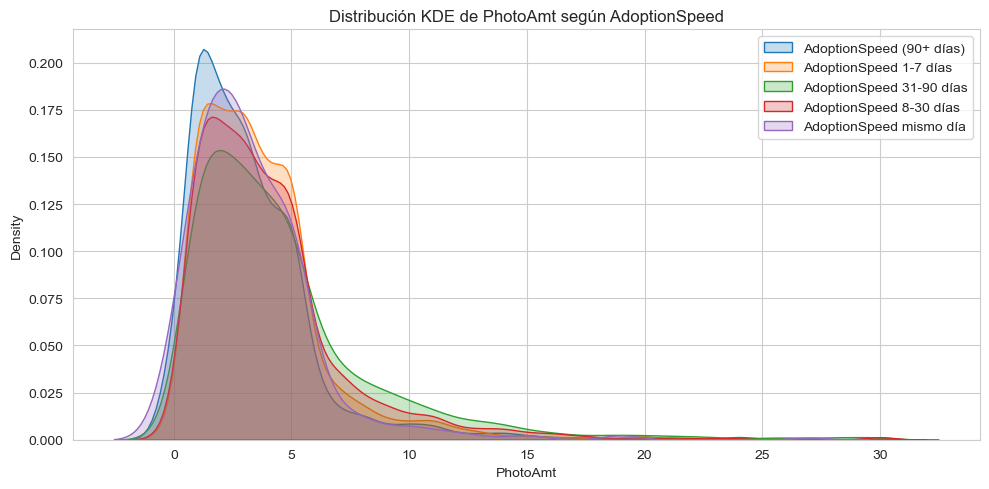

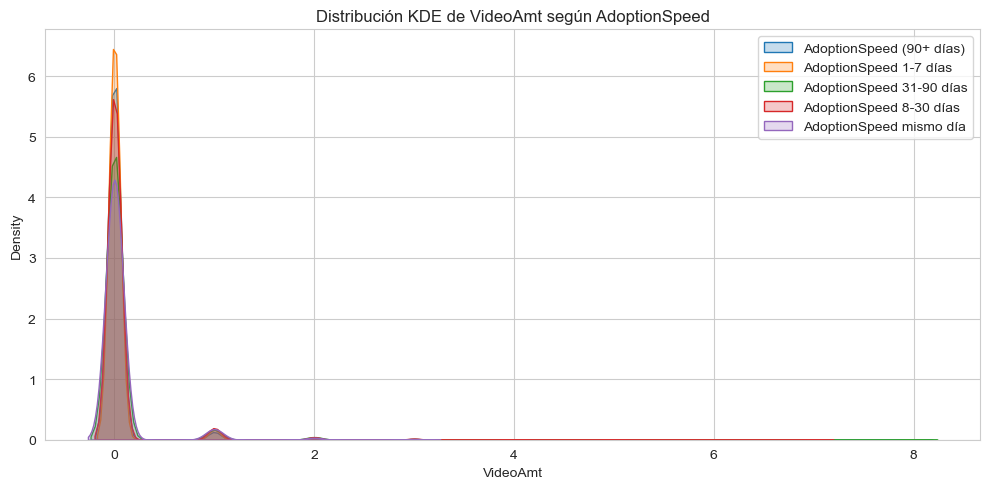

In [329]:

for col in numeric_cols:
    plot_kde_by_adoption(df_expl, col)


In [333]:
def top_k_cats_plot(df, column, k=10, target='AdoptionSpeed'):
    top_k = df[column].value_counts().head(k).index
    filtered_df = df[df[column].isin(top_k)]
    plot_categorical_distribution(filtered_df, column)

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/3965131357.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


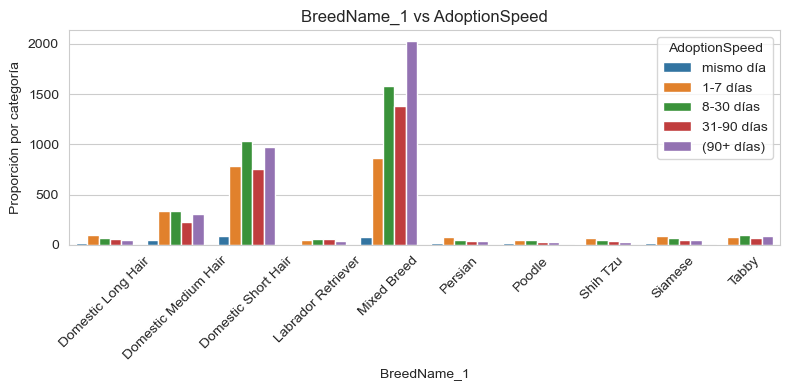

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/3965131357.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


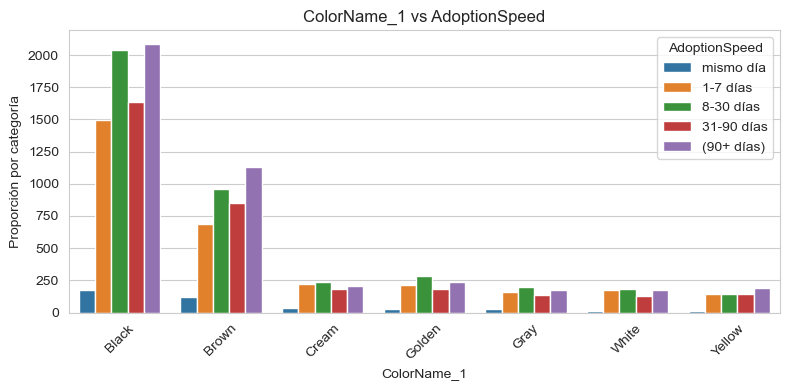

/var/folders/kp/s2gk9m_x0tbb3gq2tvx95dn40000gn/T/ipykernel_8395/3965131357.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfs.groupby([column, target]).size().reset_index(name='count')


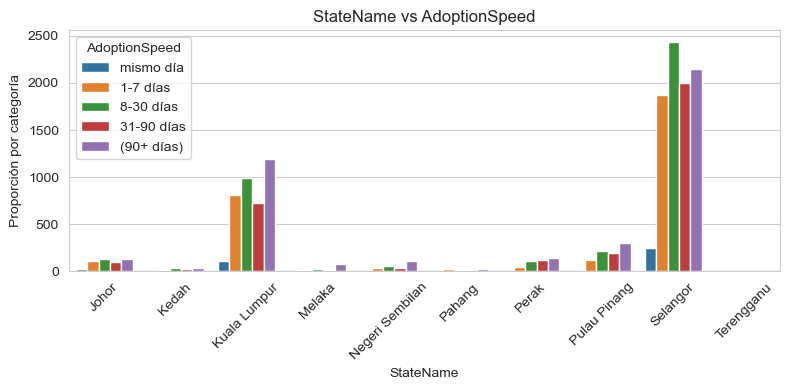

In [334]:
top_k_cats_plot(df_expl, "BreedName_1")
top_k_cats_plot(df_expl, "ColorName_1")
top_k_cats_plot(df_expl, "StateName")

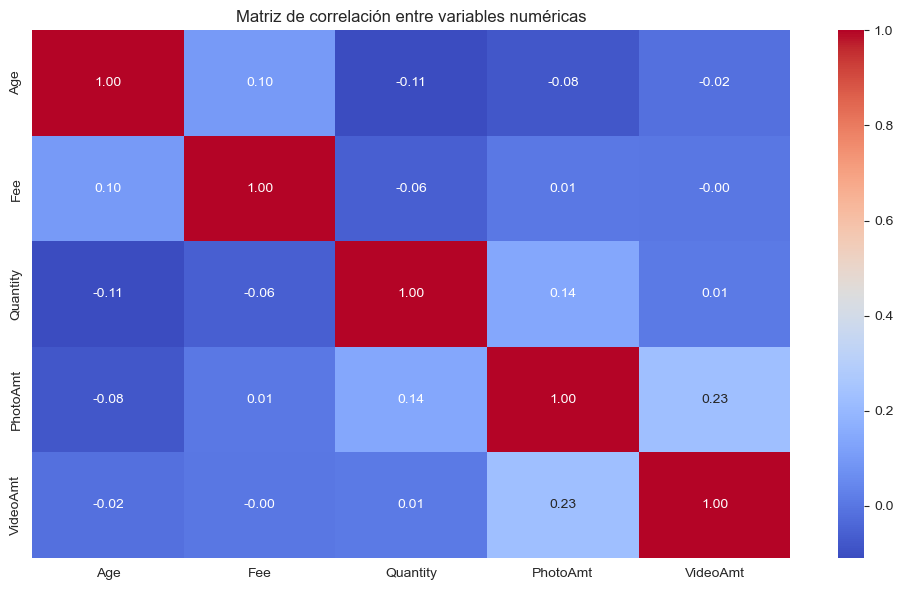

In [336]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_expl[numeric_cols ].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

## Analisis de correspondencia

In [341]:
cat_cols = [
    'Type', 'Gender', 'MaturitySize', 'FurLength', 
    'Vaccinated', 'Dewormed', 'Sterilized', 'Health'
]


In [339]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [342]:
def correspondencia_simple(df, var_cat, target='AdoptionSpeed', n_components=2, plot=True):
    """
    Realiza Análisis de Correspondencias (CA) entre una variable categórica y la target.
    Retorna los coordenadas de las categorías y muestra gráfico si se desea.
    """
    # 1. Tabla de contingencia
    contingency = pd.crosstab(df[var_cat], df[target])

    # 2. Normalización (perfil de filas)
    Z = contingency / contingency.sum().sum()

    # 3. Análisis de correspondencias usando SVD
    svd = TruncatedSVD(n_components=n_components)
    coords = svd.fit_transform(Z)

    coords_df = pd.DataFrame(coords, index=contingency.index, columns=[f"Dim{i+1}" for i in range(n_components)])

    # 4. Visualización
    if plot:
        plt.figure(figsize=(6, 5))
        plt.scatter(coords_df["Dim1"], coords_df["Dim2"])
        for i, label in enumerate(coords_df.index):
            plt.text(coords_df.iloc[i, 0], coords_df.iloc[i, 1], label, fontsize=9)
        plt.title(f"Análisis de Correspondencias: {var_cat}")
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return coords_df

🔍 Analizando Type...


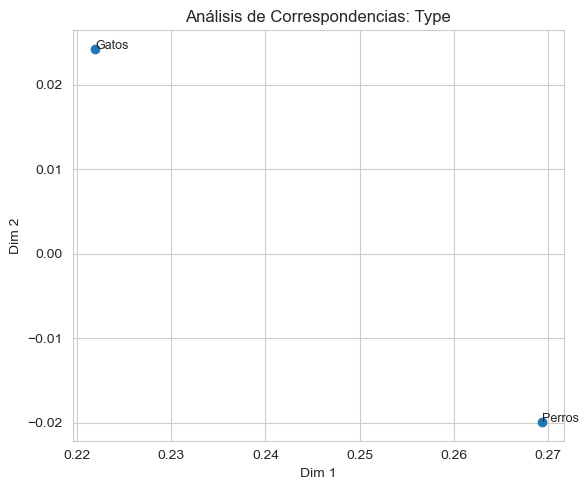

🔍 Analizando Gender...


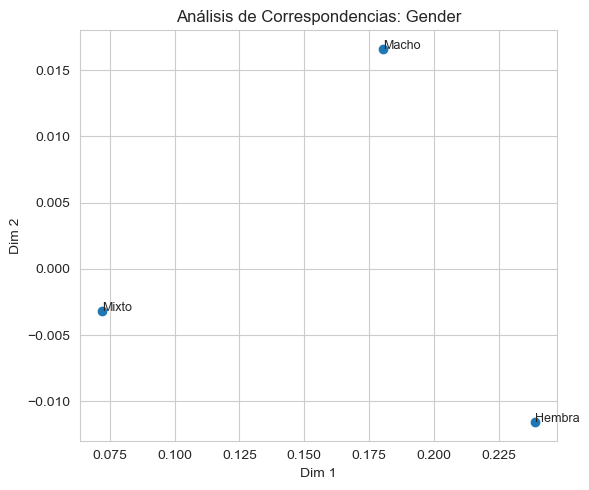

🔍 Analizando MaturitySize...


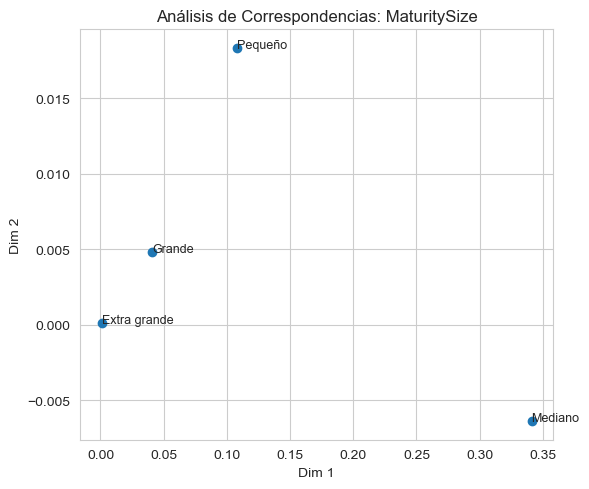

🔍 Analizando FurLength...


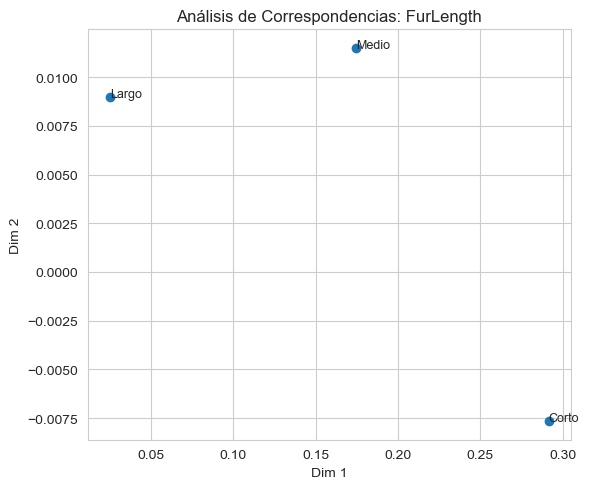

🔍 Analizando Vaccinated...


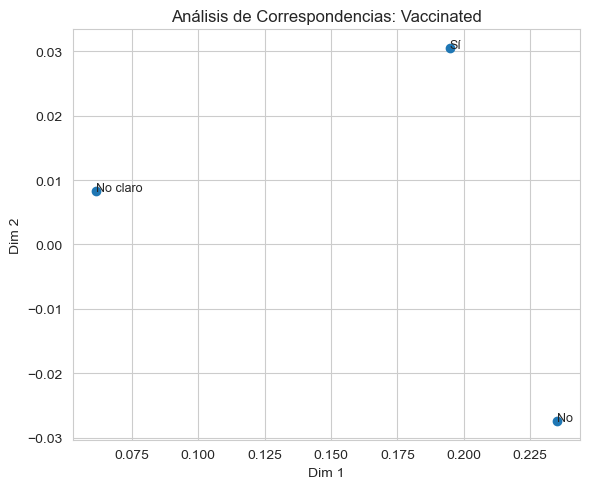

🔍 Analizando Dewormed...


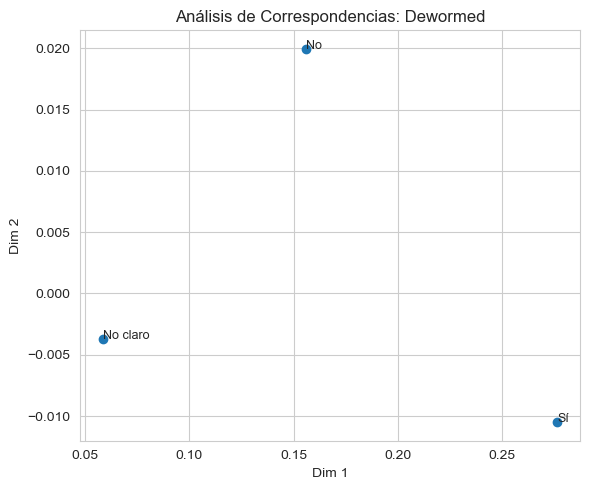

🔍 Analizando Sterilized...


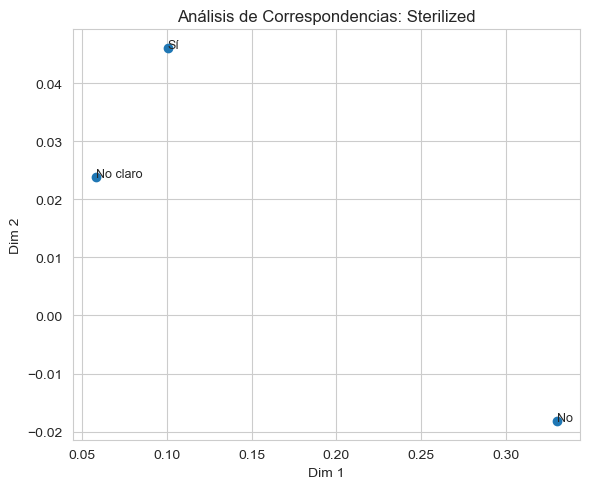

🔍 Analizando Health...


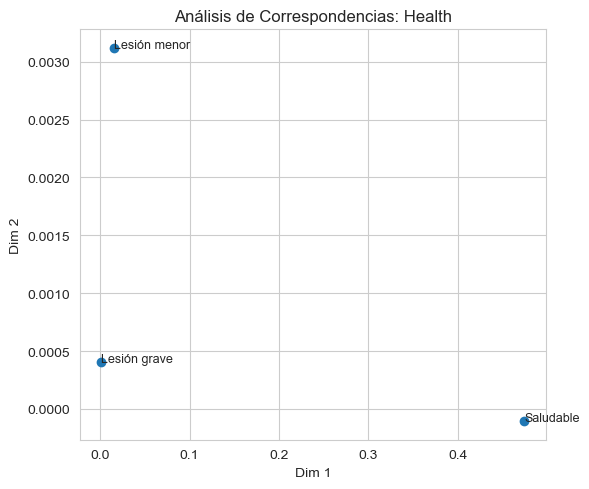

In [343]:
resultados_ca = {}

for col in cat_cols:
    print(f"🔍 Analizando {col}...")
    coords = correspondencia_simple(df_expl, col)
    resultados_ca[col] = coords

## Correspondencia Multiple

In [349]:
#!pip install prince

  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata (31 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 9.6 MB/s eta 0:00:00
Using cached scikit_learn-1.6.1-cp39-cp39-macosx_10_9_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [350]:
import prince


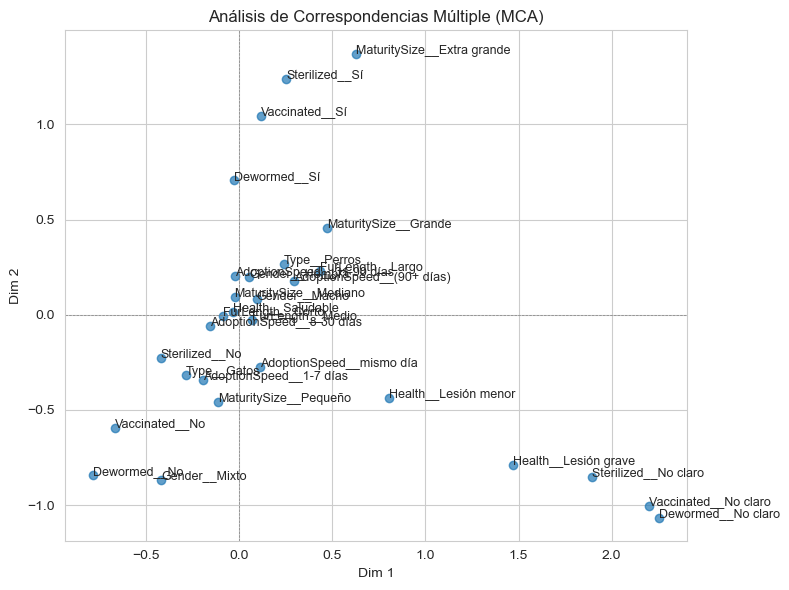

In [356]:
# Variables categóricas
cat_cols = [
    'Type', 'Gender', 'MaturitySize', 'FurLength',
    'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
    'AdoptionSpeed'
]

# Subset y aseguramos que todas sean categóricas
df_mca = df_expl[cat_cols].copy()
for col in df_mca.columns:
    df_mca[col] = df_mca[col].astype('category')

# Crear y ajustar modelo MCA
mca = prince.MCA(
    n_components=2,
    n_iter=5,
    copy=True,
    check_input=True,
    engine='sklearn',  # <-- CORREGIDO
    random_state=42
)

mca = mca.fit(df_mca)

# Coordenadas de las categorías
coords = mca.column_coordinates(df_mca)

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(coords[0], coords[1], alpha=0.7)

for i, label in enumerate(coords.index):
    plt.text(coords.iloc[i, 0], coords.iloc[i, 1], label, fontsize=9)

plt.title('Análisis de Correspondencias Múltiple (MCA)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()